# Conservative Q-Learning



--- 
**Algorithm 1** Conservative Q-Learning
--- 
1. 初始化 Q 函数 $Q_\theta$，可选地初始化策略函数 $\pi_\phi$。  
2. 对于步数 $t = 1,\dots ,N$ 执行：  
   1. 用 $G_Q$ 梯度步训练 Q 函数，最小化式$CQL(\mathcal{H})$ 的 CQL 目标  
      &nbsp;&nbsp;&nbsp;&nbsp;$\theta_t \leftarrow \theta_{t-1} - \lambda_Q \nabla_\theta \mathcal{L}_{\text{CQL}(\mathcal{H})}(\theta)$  
      （Q-learning 版本用算子 $\mathcal{B}^*$；actor-critic 版本用 $\mathcal{B}^{\pi_{\phi_t}}$）  
   2. **（仅 actor-critic 版本）** 用 $G_\pi$ 梯度步改进策略 $\pi_\phi$，采用 SAC 式的熵正则化：  
      &nbsp;&nbsp;&nbsp;&nbsp;$\phi_t \leftarrow \phi_{t-1} + \lambda_\pi \mathbb{E}_{s\sim\mathcal{D},a\sim\pi_\phi} \left[\nabla_\phi \left(Q_\theta(s,a)-\log\pi_\phi(a|s) \right)\right]$  
3. 结束循环
---

注：
- $$J = \min_Q \alpha \cdot \mathbb{E}_{s \sim \mathcal{D}}\left[log\sum_a e^{Q(s, a)}- \mathbb{E}_{a\sim \pi_\beta(a|s)}[Q(s,a)]\right] + \frac{1}{2}\mathbb{E}_{s, a, s^\prime \sim \mathcal{D}}\left[\left(Q(s, a) - \hat{\mathcal{B}}^{\pi_k}\hat{Q}^k(s, a)\right)^2\right]$$

In [1]:
# 属性标注
from typing import List, Set
# torch相关
import torch 
from torch import nn 
from torch import optim
from torch import functional as F 
# gym环境
import gymnasium as gym
import os
import copy
import random
import numpy as np 
import itertools
from collections import deque
from tqdm.auto import tqdm
from argparse import Namespace
# 日志框架
from loguru import logger
# 画图
import matplotlib.pyplot as plt
import warnings 
from IPython import display
# 画图风格
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## 1️⃣ 基础准备

- 定义网络
- 定义经验回放
- 定义策略


### 🌐 1.1 定义网络

In [2]:

class qNet(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_layers_list: List[int] = [128, 128]):
        """基础QNet
        Args:
            state_dim (int): 环境state维度
            action_dim (int): 环境action维度
            hidden_layers_list (List[int], optional): n层MLP网络输出维度. Defaults to [128, 128].
        """
        super(qNet, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        h_ = [state_dim] + hidden_layers_list
        net_l  = []
        for i, o in zip(h_[:-1], h_[1:]):
            net_l.extend(
                [nn.Linear(i, o), nn.ReLU()]
            )
        self.feature = nn.Sequential(*net_l)
        self.head = nn.Linear(hidden_layers_list[-1], action_dim)

    def forward(self, state):
        return self.head(self.feature(state))


### 🗃️ 1.2 定义经验回放

In [3]:
class replayBuffer:
    def __init__(self, capacity: int):
        self._buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self._buffer.append( (state, action, reward, next_state, done) )

    def __len__(self):
        return len(self._buffer)
    
    def sample(self, batch_size: int):
        samples = random.sample(self._buffer, batch_size)
        return samples

### 🎮 1.3 定义策略

In [4]:

class CQL_DQN:
    def __init__(self, config):
        self.state_dim = config.state_dim
        self.action_dim = config.action_dim
        self.device = config.device
        self.doubleq = config.doubleq
        self.cql_alpha = config.cql_alpha
        self.tau = getattr(config, 'tau', 0.1)
        self.cql_temperature = getattr(config, 'cql_temperature', 1)
        self.q = qNet(config.state_dim, config.action_dim, config.hidden_layers_list)
        self.tar_q = copy.deepcopy(self.q)
        
        self.q.to(self.device)
        self.tar_q.to(self.device)
        self.learning_rate = config.learning_rate
        self.opt = optim.Adam(self.q.parameters(), lr=config.learning_rate)

        self.gamma = config.gamma
        self.epsilon = config.epsilon_start
        self.epsilon_start = config.epsilon_start
        self.epsilon_end = config.epsilon_end
        self.epsilon_decay = config.epsilon_decay
        self.training = True
        self.count = 0
        self.epsilon_iter = self._epsilon_update()

    def _epsilon_update(self):
        # 指数衰减  ε_t = max(eps_end, eps_start · decay^t)
        eps = self.epsilon_start
        for _ in itertools.count():
            yield max(self.epsilon_end, eps)
            eps *= self.epsilon_decay

    def train(self):
        self.training = True 
        self.q.train()
        self.tar_q.train()
    
    def eval(self):
        self.training = False 
        self.q.eval()
        self.tar_q.eval()
    
    @torch.no_grad()
    def policy(self, state, return_q=False):
        if self.training:
            self.epsilon = next(self.epsilon_iter)
        if self.training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)

        state = torch.tensor(state[np.newaxis, ...]).float().to(self.device)
        qa = self.q(state)
        a = torch.argmax(qa, dim=-1)
        if return_q:
            return a.cpu().detach().numpy()[0], torch.max(qa).cpu().detach().numpy()
        return a.cpu().detach().numpy()[0]

    @logger.catch()
    def update(self, samples: deque):
        self.count  += 1
        # sample -> tensor
        states, actions, rewards, next_states, done = zip(*samples)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.Tensor(np.array(actions)).view(-1, 1).to(self.device)
        rewards = torch.Tensor(np.array(rewards)).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.Tensor(np.array(done)).view(-1, 1).to(self.device)

        q_sa = self.q(states)
        q_value = q_sa.gather(1, actions.long())
        next_q_sa = self.tar_q(next_states)
        if self.doubleq:
            next_qa_tar_ = self.q(next_states)
            a_star = next_qa_tar_.max(1)[1].view(-1, 1)
        else:
            a_star = next_q_sa.max(1)[1].view(-1, 1)

        next_q_value = next_q_sa.gather(1, a_star.long())
        td_target = rewards + self.gamma * next_q_value * (1 - dones)
        assert td_target.shape == q_value.shape, f'{td_target.shape=}!= {q_value.shape=}'
        critic_loss = torch.mean((q_value.float() - td_target.detach()) ** 2)

        # cql 
        critic_loss += self.cql_alpha * (
            torch.logsumexp(q_sa/self.cql_temperature, dim=1) 
            - q_sa.gather(1, actions.long().view(-1, 1))/ self.cql_temperature
        ).mean() * self.cql_temperature

        self.opt.zero_grad()
        critic_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.q.parameters(), 10)
        self.opt.step()

        # soft update 
        self.soft_update(self.q, self.tar_q)

        return {
            'q_value': q_value.detach().cpu().numpy().mean(),
            'next_q_value': next_q_value.detach().cpu().numpy().mean(),
            'critic_loss': critic_loss.detach().cpu().numpy(),
            'grad_norm': grad_norm.detach().cpu().numpy(),
            'epsilon': self.epsilon,
        }

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)


## 2️⃣  策略训练

- 参数设置
  - <b><font color=red>todo</font></b>: 读者如果在实际工程应用中配置，推荐学习和使用[【OmegaConf】](https://omegaconf.readthedocs.io/en/2.3_branch/usage.html)
- 训练函数
- agent训练

### ⚙️ 2.1 参数设置

这部分可以先不深究，直接用dict也是可以的

In [5]:
class baseConfig(Namespace):
    """
    Config 强制校验
    """
    __required__: Set[str] = set()

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        missing = self.__required__ - self.__dict__.keys()
        if missing:
            raise ValueError(
                f"{self.__class__.__name__} 缺少必填属性: {', '.join(missing)}"
            )


class _tainConfig(baseConfig):
    __required__ = {
        'num_episode',
        'max_episode_steps',
        'off_buffer_size',
        'sample_size',
        'off_minimal_size',
        'seed'
    }


class _modelConfig(baseConfig):
    __required__ = {
        "state_dim",
        "action_dim",
        "device",
        "doubleq",
        "cql_alpha",
        "hidden_layers_list",
        "learning_rate",
        "gamma",
        "epsilon_start",
        "epsilon_end",
        "epsilon_decay"
    }


class CQLConfig(baseConfig):
    __required__ = {"train", "agent"}   # 这里要求两个子配置也必须给

    def __init__(self, **kwargs):
        # 先让子配置各自校验
        self.train = _tainConfig(**kwargs.pop("train"))
        self.agent = _modelConfig(**kwargs.pop("agent"))
        # 再把剩下的全局字段放到顶层 Namespace
        super().__init__(**kwargs)


In [6]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
config = CQLConfig(
    train=dict(
        num_episode=200,
        max_episode_steps=200,
        off_buffer_size=12000,
        sample_size=64,
        off_minimal_size=1024,
        seed=202511
    ),
    agent=dict(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.n,
        hidden_layers_list=[64, 64],
        gamma=0.95,
        learning_rate=5.5e-4,
        cql_alpha=1.2,
        device='cuda',
        doubleq=True,
        epsilon_start=0.95,    # e-greedy 指数衰减策略中初始epsilon
        epsilon_end=0.01,      # e-greedy 指数衰策略中的终止epsilon,
        epsilon_decay=0.995,   # e-greedy 指数衰策略中epsilon的衰减率, start * decsy ^ t
        tau=0.005
    )
)

### 🔄 2.2 训练函数

- `train_off_policy`: 简单的off-policy 训练DQN 并收集数据 
  - <b><font color=red>todo</font></b>: 读者也可以直接用`minari`到Huggingface上下载数据
  - <b><font color=red>todo</font></b>: 读者可以将训练过程数据用 swandb、wandb或tensorboard 记录
- batch rl CQL训练
- 训练策略评估-`play`
  - 这个在离线强化学习实际应用中是不大可行的，需要结合业务去定义评估方法
  - 并且需要衡量Reward是否真的符合预期

In [7]:

def random_action(env):
    asp = env.action_space
    try:
        return asp.sample()
    except Exception as e:
        return np.random.choice(asp.n)


def train_off_policy(
        env, agent ,cfg, 
        train_without_seed=False,
        update_every=1,
        test_ep_freq=100,
        test_episode_count=3,
        return_buffer=False
    ):
    buffer_ = replayBuffer(cfg.off_buffer_size)
    tq_bar = tqdm(range(cfg.num_episode))
    rewards_list = []
    now_reward = -np.inf
    recent_best_reward = -np.inf
    best_ep_reward = -np.inf
    policy_idx = 0
    tt_steps = 0
    for i in tq_bar:
        if (1 + i) % test_ep_freq == 0:
            freq_ep_reward = play(env, agent, cfg, episode_count=test_episode_count, play_without_seed=train_without_seed, render=False)
            # todo 读者可以自己在这里补充模型保存代码

        rand_seed = np.random.randint(0, 999999)
        final_seed = rand_seed if train_without_seed else cfg.seed
        s, _ = env.reset(seed=final_seed)
        tq_bar.set_description(f'Episode [ {i+1} / {cfg.num_episode}|(seed={final_seed}) ]')
        done = False
        episode_rewards = 0
        steps = 0
        up_res = {}
        for st in range(cfg.max_episode_steps):
            if len(buffer_) < cfg.off_minimal_size:
                a = random_action(env)
            else:
                a = agent.policy(s)
                if policy_idx == 0:
                    rewards_list = []
                    print('Finished collect orginal data')

                policy_idx += 1

            n_s, r, terminated, truncated, _ = env.step(a)
            
            done = np.logical_or(terminated, truncated)
            steps += 1
            tt_steps += 1
            # state, action, reward, next_state, done
            buffer_.add(s, a, r, n_s, done)
            s = n_s
            episode_rewards += r
            # buffer update
            if (len(buffer_) >= cfg.off_minimal_size) and (tt_steps % update_every == 0):
                samples = buffer_.sample(cfg.sample_size)
                up_res = agent.update(samples)

            if done:
                break

        if (len(buffer_) >= cfg.off_minimal_size) and (i >= 10):
            rewards_list.append(episode_rewards)
            now_reward = np.mean(rewards_list[-10:])
        if (now_reward > recent_best_reward) and (i >= 10) and (len(buffer_) >= cfg.off_minimal_size):
            # best 时也进行测试
            test_ep_reward = play(env, agent, cfg, episode_count=test_episode_count, play_without_seed=train_without_seed, render=False)
            if test_ep_reward > best_ep_reward:
                best_ep_reward = test_ep_reward
                # todo 读者可以自己在这里补充模型保存代码

            recent_best_reward = now_reward
        
        up_res.update({
            "steps": steps,
            'lastMeanRewards': f'{now_reward:.2f}',
            'BEST': f'{recent_best_reward:.2f}',
            "bestTestReward": f'{best_ep_reward:.2f}'
        })
        tq_bar.set_postfix(up_res)

    env.close()
    if return_buffer:
        return agent, buffer_, rewards_list
    return agent, rewards_list


@torch.no_grad()
def play(env_in, env_agent, cfg, episode_count=2, play_without_seed=False, render=False, return_q=False):
    """
    对训练完成的Agent进行游戏
    """
    max_steps = cfg.max_episode_steps
    env = copy.deepcopy(env_in)
    ep_reward_record = []
    ep_q_value_record = []
    for e in range(episode_count):
        final_seed = np.random.randint(0, 999999) if play_without_seed else cfg.seed
        s, _ = env.reset(seed=final_seed)
        done = False
        episode_reward = 0
        episode_cnt = 0
        episode_q = []
        for i in range(max_steps):
            if render:
                env.render()
            if return_q:
                a, q_i = env_agent.policy(s, return_q)
                episode_q.append(q_i)
            else:
                a = env_agent.policy(s)
            n_state, reward, terminated, truncated, info = env.step(a)
            done = terminated or truncated 
            episode_reward += reward
            episode_cnt += 1
            s = n_state
            if done:
                break

        ep_reward_record.append(episode_reward)
        ep_q_value_record.append(np.mean(episode_q))
        add_str = ''
        print(f'[ {add_str}seed={final_seed} ] Get reward {episode_reward:.2f}. Last {episode_cnt} times')
    
    if render:
        env.close()

    print(f'[ {add_str}PLAY ] Get reward {np.mean(ep_reward_record):.2f}.')
    if return_q:
        return np.mean(ep_reward_record), np.mean(ep_q_value_record)
    return np.mean(ep_reward_record)


def simple_batch_rl(env, agent, config, buffer_, num_iterations=800, c=None, return_q=False):
    res_ = []
    q_l = []
    tr_bar = tqdm(range(num_iterations))
    tr_bar.set_description(f'CQL Training (cql_alpha={c})' if c is not None else 'CQL Training')
    for it in tr_bar:
        agent.train()
        res = agent.update(buffer_.sample(config.sample_size))
        tr_bar.set_postfix(res)
        if it % 5 == 0:
            agent.eval()
            t_ = play(env, agent, config, episode_count=5, play_without_seed=True, render=False, return_q=return_q)
            if return_q:
                q_l.append(t_[1])
                res_.append(t_[0])
                continue
            res_.append(t_)
            
    return res_, q_l

### 🤖 2.3 agent训练

- 设置随机种子保证可复现

In [8]:
def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))


def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  


In [9]:
all_seed(config.train.seed)

In [10]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

dqn_config = copy.deepcopy(config)
dqn_agent_cfg = dqn_config.agent
dqn_agent_cfg.cql_alpha = 0.0 # 纯DQN
dqn_agent_cfg.learning_rate = 2.0e-3
dqn_agent_cfg

_modelConfig(state_dim=4, action_dim=2, hidden_layers_list=[64, 64], gamma=0.95, learning_rate=0.002, cql_alpha=0.0, device='cuda', doubleq=True, epsilon_start=0.95, epsilon_end=0.01, epsilon_decay=0.995, tau=0.005)

In [11]:
print("Double-DQN Hyperparameters")
print_cfgs(dqn_config.train)
print_cfgs(dqn_config.agent)

Double-DQN Hyperparameters
Hyperparameters:
        Name        	       Value        	        Type        
    num_episode     	        200         	   <class 'int'>    
 max_episode_steps  	        200         	   <class 'int'>    
  off_buffer_size   	       12000        	   <class 'int'>    
    sample_size     	         64         	   <class 'int'>    
  off_minimal_size  	        1024        	   <class 'int'>    
        seed        	       202511       	   <class 'int'>    
Hyperparameters:
        Name        	       Value        	        Type        
     state_dim      	         4          	   <class 'int'>    
     action_dim     	         2          	<class 'numpy.int64'>
 hidden_layers_list 	      [64, 64]      	   <class 'str'>    
       gamma        	        0.95        	  <class 'float'>   
   learning_rate    	       0.002        	  <class 'float'>   
     cql_alpha      	        0.0         	  <class 'float'>   
       device       	        cuda        	   <class 'str

In [12]:
# 1- 训练DQN & 收集数据
dqn = CQL_DQN(dqn_agent_cfg)
dqn.train()
dqn, buffer_, rewards_list = train_off_policy(
    env, dqn , dqn_config.train, 
    train_without_seed=True,
    update_every=1,
    test_ep_freq=100,
    test_episode_count=3,
    return_buffer=True
)

  0%|          | 0/200 [00:00<?, ?it/s]

Finished collect orginal data
[ seed=23460 ] Get reward 17.00. Last 17 times
[ seed=377770 ] Get reward 14.00. Last 14 times
[ seed=494799 ] Get reward 22.00. Last 22 times
[ PLAY ] Get reward 17.67.
[ seed=113796 ] Get reward 20.00. Last 20 times
[ seed=4257 ] Get reward 17.00. Last 17 times
[ seed=555818 ] Get reward 15.00. Last 15 times
[ PLAY ] Get reward 17.33.
[ seed=314569 ] Get reward 192.00. Last 192 times
[ seed=56127 ] Get reward 200.00. Last 200 times
[ seed=649980 ] Get reward 200.00. Last 200 times
[ PLAY ] Get reward 197.33.
[ seed=990505 ] Get reward 151.00. Last 151 times
[ seed=521758 ] Get reward 128.00. Last 128 times
[ seed=214832 ] Get reward 87.00. Last 87 times
[ PLAY ] Get reward 122.00.
[ seed=805845 ] Get reward 97.00. Last 97 times
[ seed=945580 ] Get reward 104.00. Last 104 times
[ seed=482389 ] Get reward 107.00. Last 107 times
[ PLAY ] Get reward 102.67.
[ seed=502009 ] Get reward 128.00. Last 128 times
[ seed=678865 ] Get reward 101.00. Last 101 times
[ 

In [13]:
# 2- batch RL
cql_agent_cfg = config.agent
print("CQL Hyperparameters")
print_cfgs(config.train)
print_cfgs(config.agent)

CQL Hyperparameters
Hyperparameters:
        Name        	       Value        	        Type        
    num_episode     	        200         	   <class 'int'>    
 max_episode_steps  	        200         	   <class 'int'>    
  off_buffer_size   	       12000        	   <class 'int'>    
    sample_size     	         64         	   <class 'int'>    
  off_minimal_size  	        1024        	   <class 'int'>    
        seed        	       202511       	   <class 'int'>    
Hyperparameters:
        Name        	       Value        	        Type        
     state_dim      	         4          	   <class 'int'>    
     action_dim     	         2          	<class 'numpy.int64'>
 hidden_layers_list 	      [64, 64]      	   <class 'str'>    
       gamma        	        0.95        	  <class 'float'>   
   learning_rate    	      0.00055       	  <class 'float'>   
     cql_alpha      	        1.2         	  <class 'float'>   
       device       	        cuda        	   <class 'str'>    


In [14]:

final_r = {}
final_q = {}
env_name = 'CartPole-v1'
env = gym.make(env_name)
for c in [0.05, 0.5, 1.0, 1.2, 1.5]:
    cql_agent_cfg.cql_alpha = c
    agent = CQL_DQN(cql_agent_cfg)
    res_, q_l_ = simple_batch_rl(env, agent, config.train, buffer_, num_iterations=800, c=c, return_q=True)
    final_r[c] = res_
    final_q[c] = q_l_


  0%|          | 0/800 [00:00<?, ?it/s]

[ seed=573111 ] Get reward 9.00. Last 9 times
[ seed=607295 ] Get reward 10.00. Last 10 times
[ seed=545420 ] Get reward 9.00. Last 9 times
[ seed=386457 ] Get reward 10.00. Last 10 times
[ seed=643826 ] Get reward 10.00. Last 10 times
[ PLAY ] Get reward 9.60.
[ seed=340907 ] Get reward 10.00. Last 10 times
[ seed=706104 ] Get reward 10.00. Last 10 times
[ seed=890116 ] Get reward 9.00. Last 9 times
[ seed=800509 ] Get reward 10.00. Last 10 times
[ seed=500994 ] Get reward 9.00. Last 9 times
[ PLAY ] Get reward 9.60.
[ seed=998494 ] Get reward 10.00. Last 10 times
[ seed=916403 ] Get reward 9.00. Last 9 times
[ seed=822818 ] Get reward 9.00. Last 9 times
[ seed=608947 ] Get reward 8.00. Last 8 times
[ seed=515604 ] Get reward 10.00. Last 10 times
[ PLAY ] Get reward 9.20.
[ seed=478208 ] Get reward 9.00. Last 9 times
[ seed=268847 ] Get reward 10.00. Last 10 times
[ seed=704989 ] Get reward 10.00. Last 10 times
[ seed=692820 ] Get reward 9.00. Last 9 times
[ seed=425097 ] Get reward 1

  0%|          | 0/800 [00:00<?, ?it/s]

[ seed=260149 ] Get reward 10.00. Last 10 times
[ seed=775718 ] Get reward 11.00. Last 11 times
[ seed=965448 ] Get reward 10.00. Last 10 times
[ seed=20525 ] Get reward 8.00. Last 8 times
[ seed=404891 ] Get reward 9.00. Last 9 times
[ PLAY ] Get reward 9.60.
[ seed=929603 ] Get reward 11.00. Last 11 times
[ seed=222275 ] Get reward 13.00. Last 13 times
[ seed=497857 ] Get reward 12.00. Last 12 times
[ seed=29682 ] Get reward 16.00. Last 16 times
[ seed=598938 ] Get reward 13.00. Last 13 times
[ PLAY ] Get reward 13.00.
[ seed=793138 ] Get reward 21.00. Last 21 times
[ seed=447111 ] Get reward 21.00. Last 21 times
[ seed=447684 ] Get reward 23.00. Last 23 times
[ seed=819906 ] Get reward 17.00. Last 17 times
[ seed=217408 ] Get reward 19.00. Last 19 times
[ PLAY ] Get reward 20.20.
[ seed=215651 ] Get reward 19.00. Last 19 times
[ seed=473701 ] Get reward 17.00. Last 17 times
[ seed=857225 ] Get reward 17.00. Last 17 times
[ seed=985859 ] Get reward 23.00. Last 23 times
[ seed=826987 

  0%|          | 0/800 [00:00<?, ?it/s]

[ seed=458515 ] Get reward 10.00. Last 10 times
[ seed=532039 ] Get reward 8.00. Last 8 times
[ seed=697333 ] Get reward 9.00. Last 9 times
[ seed=234287 ] Get reward 9.00. Last 9 times
[ seed=306339 ] Get reward 10.00. Last 10 times
[ PLAY ] Get reward 9.20.
[ seed=323611 ] Get reward 8.00. Last 8 times
[ seed=795808 ] Get reward 10.00. Last 10 times
[ seed=97698 ] Get reward 8.00. Last 8 times
[ seed=113539 ] Get reward 8.00. Last 8 times
[ seed=431649 ] Get reward 8.00. Last 8 times
[ PLAY ] Get reward 8.40.
[ seed=705755 ] Get reward 8.00. Last 8 times
[ seed=879719 ] Get reward 9.00. Last 9 times
[ seed=49731 ] Get reward 9.00. Last 9 times
[ seed=924445 ] Get reward 9.00. Last 9 times
[ seed=890894 ] Get reward 10.00. Last 10 times
[ PLAY ] Get reward 9.00.
[ seed=215668 ] Get reward 10.00. Last 10 times
[ seed=863638 ] Get reward 8.00. Last 8 times
[ seed=519264 ] Get reward 9.00. Last 9 times
[ seed=869120 ] Get reward 8.00. Last 8 times
[ seed=502077 ] Get reward 10.00. Last 1

  0%|          | 0/800 [00:00<?, ?it/s]

[ seed=553701 ] Get reward 13.00. Last 13 times
[ seed=811747 ] Get reward 13.00. Last 13 times
[ seed=449459 ] Get reward 11.00. Last 11 times
[ seed=176730 ] Get reward 12.00. Last 12 times
[ seed=617878 ] Get reward 10.00. Last 10 times
[ PLAY ] Get reward 11.80.
[ seed=839200 ] Get reward 15.00. Last 15 times
[ seed=615035 ] Get reward 15.00. Last 15 times
[ seed=345607 ] Get reward 13.00. Last 13 times
[ seed=872244 ] Get reward 16.00. Last 16 times
[ seed=150218 ] Get reward 13.00. Last 13 times
[ PLAY ] Get reward 14.40.
[ seed=18802 ] Get reward 14.00. Last 14 times
[ seed=83525 ] Get reward 17.00. Last 17 times
[ seed=724184 ] Get reward 17.00. Last 17 times
[ seed=741874 ] Get reward 16.00. Last 16 times
[ seed=781298 ] Get reward 14.00. Last 14 times
[ PLAY ] Get reward 15.60.
[ seed=267728 ] Get reward 20.00. Last 20 times
[ seed=169766 ] Get reward 17.00. Last 17 times
[ seed=417352 ] Get reward 13.00. Last 13 times
[ seed=724167 ] Get reward 15.00. Last 15 times
[ seed=90

  0%|          | 0/800 [00:00<?, ?it/s]

[ seed=236978 ] Get reward 11.00. Last 11 times
[ seed=198216 ] Get reward 9.00. Last 9 times
[ seed=785685 ] Get reward 11.00. Last 11 times
[ seed=774124 ] Get reward 10.00. Last 10 times
[ seed=68351 ] Get reward 9.00. Last 9 times
[ PLAY ] Get reward 10.00.
[ seed=703930 ] Get reward 9.00. Last 9 times
[ seed=135818 ] Get reward 9.00. Last 9 times
[ seed=860570 ] Get reward 8.00. Last 8 times
[ seed=400957 ] Get reward 9.00. Last 9 times
[ seed=446739 ] Get reward 9.00. Last 9 times
[ PLAY ] Get reward 8.80.
[ seed=82932 ] Get reward 8.00. Last 8 times
[ seed=99073 ] Get reward 8.00. Last 8 times
[ seed=640319 ] Get reward 10.00. Last 10 times
[ seed=113549 ] Get reward 10.00. Last 10 times
[ seed=311696 ] Get reward 10.00. Last 10 times
[ PLAY ] Get reward 9.20.
[ seed=883305 ] Get reward 10.00. Last 10 times
[ seed=800942 ] Get reward 10.00. Last 10 times
[ seed=541285 ] Get reward 10.00. Last 10 times
[ seed=608056 ] Get reward 9.00. Last 9 times
[ seed=225427 ] Get reward 10.00

## 3️⃣ 策略效果查看

- `plot_result`： 训练情况绘制
- 环境实际表现

In [15]:

def plot_result(return_list, n_smooth=10, title=None, ax=None):
    ax = plt if ax is None else ax
    smooth_avg = np.array([np.mean(return_list[max(0, e-n_smooth):e]) for e in range(1, len(return_list))])
    smooth_std = np.array([np.std(return_list[max(0, e-n_smooth):e]) for e in range(1, len(return_list))])

    ax.plot(smooth_avg)
    ax.fill_between(
        list(range(len(smooth_avg))), 
        y1=smooth_avg - smooth_std*1.2, 
        y2=smooth_avg + smooth_std*1.2,  
        color='green',
        alpha=0.2
    )
    if title is not None:
        if ax is None:
            plt.title(title)
        else:
            ax.set_title(title)


### 📈 3.1 训练情况绘制

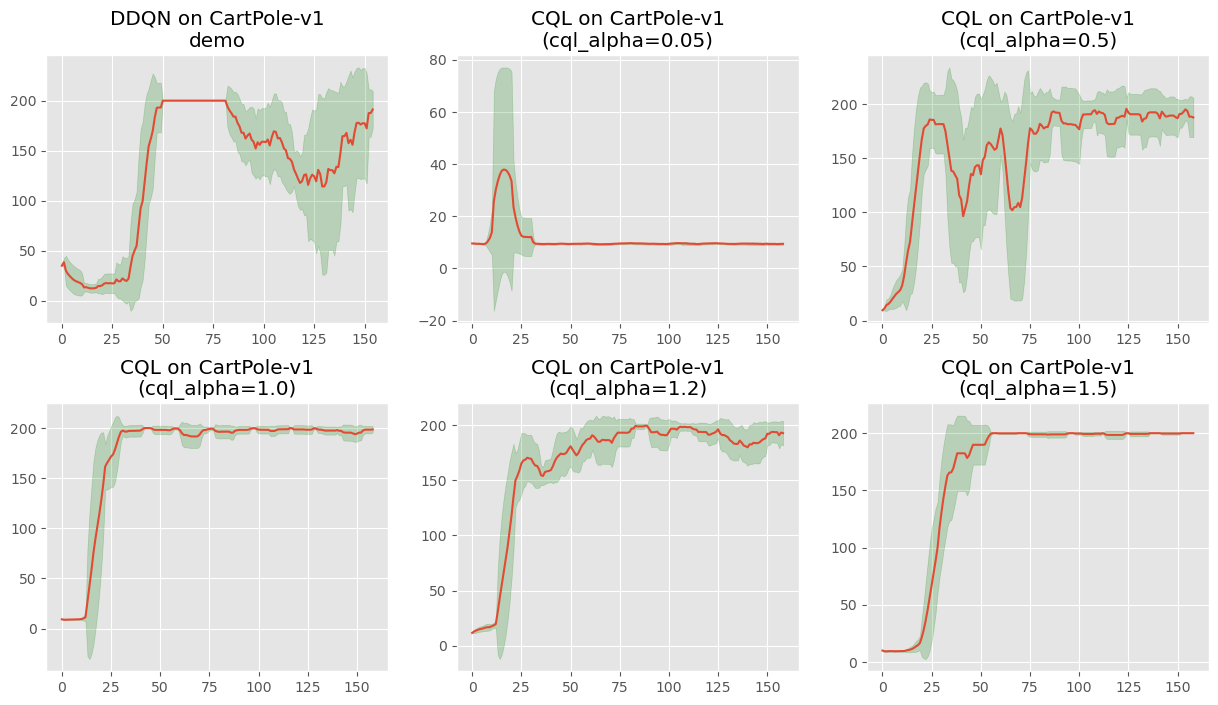

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()
plot_result(rewards_list, title=f'DDQN on {env_name}\ndemo', ax=axes[0])
for i, (c, res_) in enumerate(final_r.items()):
    plot_result(res_, title=f'CQL on {env_name}\n(cql_alpha={c})', ax=axes[i+1])


plt.show()

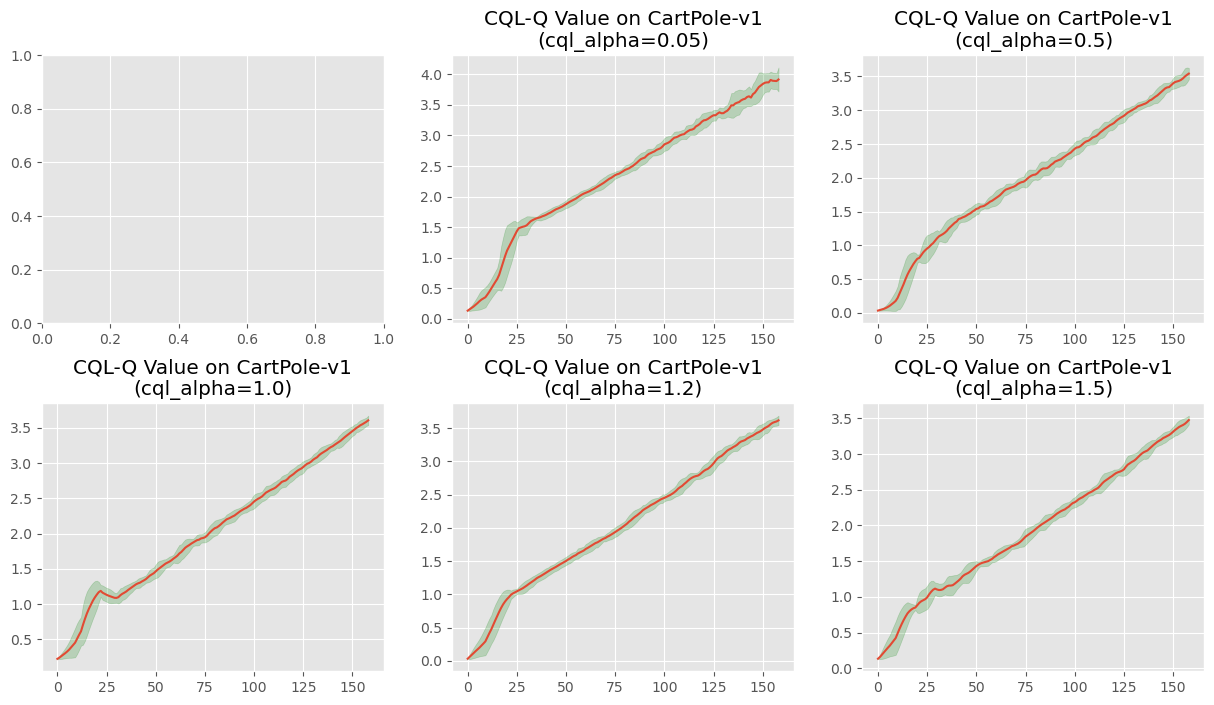

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()
for i, (c, res_) in enumerate(final_q.items()):
    plot_result(res_, title=f'CQL-Q Value on {env_name}\n(cql_alpha={c})', ax=axes[i+1])

plt.show()

### 🎥 3.2 环境实际表现

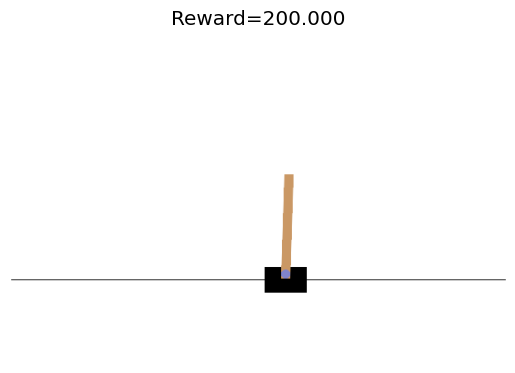

In [20]:
env = gym.make(env_name, render_mode='rgb_array')

total_r = []
for test_i in range(5):
    s, _ = env.reset()
    agent.eval()
    done = False
    img = plt.imshow(env.render())
    plt.xticks([])
    plt.yticks([])
    r_ep = 0
    for i in range(200):
        a = agent.policy(s)
        n_s, r, terminated, truncated, _ = env.step(a)
        r_ep += r
        done = np.logical_or(terminated, truncated)
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        s = n_s
        if done:
            break
    
    total_r.append(r_ep)

plt.title(f'Reward={np.mean(total_r):.3f}')
plt.show()